1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
[[ 3.88609764e-11  2.00258473e-11 -6.14039433e-12 ...  7.18527834e-11
   6.30999901e-11  5.28913732e-11]
 [ 4.22713063e-11 -4.21810208e-12 -7.47142103e-11 ...  9.68185415e-11
   9.70535132e-11  8.82608460e-11]
 [-1.04283112e-11 -1.10394684e-10 -2.65076018e-10 ...  6.05236802e-11
   9.61019073e-11  1.06190377e-10]
 ...
 [-3.23628654e-11 -4.28295366e-11 -5.42812056e-11 ... -1.05692786e-11
  -9.47940622e-12 -7.89088363e-12]
 [-1.51513751e-11 -2.01164052e-11 -2.57783999e-11 ... -6.36152554e-12
  -5.70061910e-12 -4.70429831e-12]
 [-5.66449319e-12 -7.64072591e-12 -1.01181869e-11 ... -3.00759167e-12
  -2.76818520e-12 -2.29763305e-12]]


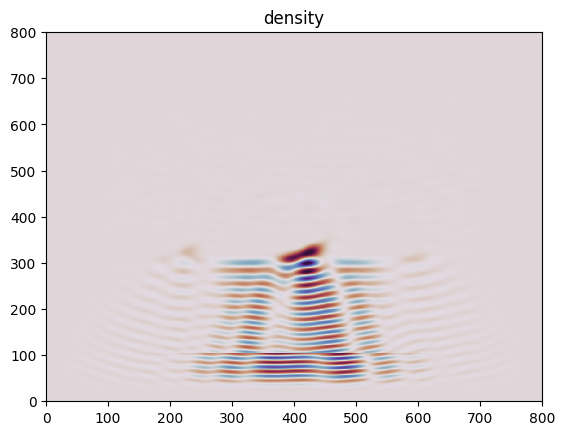

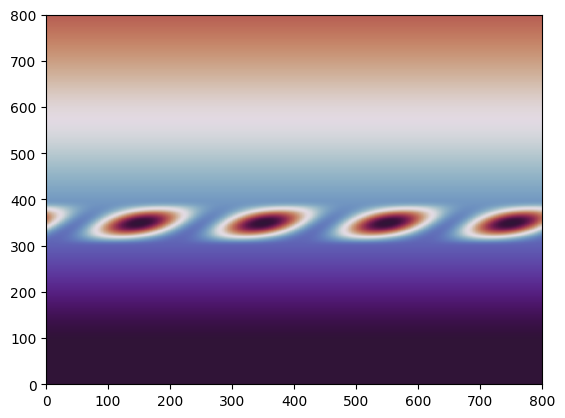

In [13]:
#NOUVEAU CODE

import sys
import numpy as np
from numba import jit #library for calculation in C
import math
import cmath
import os
import glob
import h5py as h5
import copy
import time
import random as rand
from scipy.interpolate import griddata
from scipy.signal import medfilt
from scipy.signal import savgol_filter
from scipy.signal import chirp, sweep_poly
import multiprocessing as mp
import matplotlib.pyplot as plt
import matplotlib.cm as cm

path_fluid='Turbulence_map45.h5'
path_Working='' #path for the working directory
sys.path.append(path_Working)


###############################################################################
# PHYSICS CONSTANTS
###############################################################################
c = 3.E8
ep0 = 8.85418782E-12
mu0 = 1.25663706E-6
e = 1.602E-19
me = 9.109E-31 

###############################################################################
# SIMULATION INPUT
###############################################################################
T=0                      #time point if an hdf5 file used
ind_phi_stable=5000      #time when phase is stabilized
f0=75E9                  #probing frequency
n_max=6e19               #maximum density for a linear profile
mode_A=6e19 
NX=800                   #grid size
NY=800
Xpml = 100               #PML size, to be smaller than NX, NY
Ypml = 100
tmax = 5500              #time step to stop the wave propagation
tsweep=tmax #when a frequency sweep starts - put >tmax to ignore this function
df0=0.25E9
f_steps=1
comment='test_code'

w0 = 2*math.pi*f0
dt = 1/(40.*f0) # 
dx = 2*c*dt 
dy = 2*c*dt
B_ampl=2.5*1.65           #Magnetic field amplitude 2.5 T at axes 1.65 m
plasma_size_x=NX*dx 
""" in m, minimum 6 wave lengths -> appr. 120 points after PML layer with 0 density
to avoid parasitic reflections, 0.13 for previous simul. plus the size of actual plasma"""
plasma_size_y=NY*dy
x_start=2.12              #position of the plasma box left edge
sourcei = Xpml+5          #Antenna position right in front of PML 
sourcej = int(NY/2.)      #Antenna position by default at the center of the box
waist = int(0.025/dx)     #waist of the beam
sourcewidth=2*waist       #size of the antenna
# sweep rates for a sweep test 
v_f=25e15/1               #25e17/1 25GHz in 0.01us slow sweep v_f=25e15/1  0.4GHz 45000 tps
v_w=2*math.pi*v_f         #25GHz in 0.01us
dop =0.0                  #shift to launch wave with an agle
profile_type=3            #0 zero 1 linear 2 GYSELA 3 fluid turbulence
angle='45°'


def init(t,p,sigma,ww,tstart):
    """" Defines the source of the reflectometer signal at the antenna's plane"""
    if t>tstart*dt:
        return math.exp(-p**2/sigma**2)*cmath.exp(1j*((w0+v_w*(t-dt*tstart))*t-dt*v_w*(t-dt)))*(math.tanh(t/dt/10. - 3) + 1)/2./math.sqrt(mu0/ep0)
    else:
        return math.exp(-p**2/sigma**2)*cmath.exp(1j*(ww*t-dop*p))*(math.tanh(t/dt/10. - 3) + 1)/2./math.sqrt(mu0/ep0)

class loadHDF5():
    """"Loads hdf5"""
    def __init__(self, filename):
        fh5       = h5.File(filename, 'r')
        var_in_h5 = list(fh5.keys())
        self.keys = var_in_h5

        for str_var in var_in_h5:
            str_var_new = str_var.replace('%','_')
            var_tmp     = fh5[str_var]
            self.__dict__[str_var_new] = var_tmp
        fh5.close()                

class grid:
    """"Grid of the simulation which includes fields, currents and plasma frequencies"""
    def __init__(self, length, width, xpml, ypml):
        
        self.length = length
        self.width = width
        self.xpml = xpml
        self.ypml = ypml
        
        self.Er = np.full((length, width+1), 0. + 0j)
        self.Ey = np.full((length+1, width), 0. + 0j)
        self.Jr = np.full((length, width+1), 0. + 0j)
        self.Jy = np.full((length+1, width), 0. + 0j)
        self.Hz = np.full((length, width), 0. + 0j)
        self.Hz_source = []
        self.res = []

        self.Hzx = np.full((length, width), 0. + 0j)
        self.Hzy = np.full((length, width), 0. + 0j)
        self.sxpml = np.full((length, width), 0.)
        self.ssxpml = np.full((length, width), 0.)
        self.sypml = np.full((length, width), 0.)
        self.ssypml = np.full((length, width), 0.)

        self.density = np.full((length, width), 0.)
        self.B0 = np.full((length, width), 0.)
        self.wc = np.array([[e*self.B0[j,i]/me for i in range(width)]for j in range(length)])
        self.wp = np.sqrt(self.density*e**2/(ep0*me))

    
    def clear(self):
        self.Er = np.full((self.length, self.width+1), 0. + 0j)
        self.Ey = np.full((self.length+1, self.width), 0. + 0j)
        self.Jr = np.full((self.length, self.width+1), 0. + 0j)
        self.Jy = np.full((self.length+1, self.width), 0. + 0j)
        self.Hz = np.full((self.length, self.width), 0. + 0j)
        self.Hzx = np.full((self.length, self.width), 0. + 0j)
        self.Hzy = np.full((self.length, self.width), 0. + 0j)
        self.res = []
        self.Hz_source = []
        
    def next_step(self, t, sourcei, sourcej, source_width,f):
        """"One step of the simulation redefinig the source and calculating all the fields"""
        w = 2*math.pi*f
        self.res.append(self.Ey[sourcei,sourcej])
        width = self.width
        length = self.length
        xpml = self.xpml
        ypml = self.ypml

        for j in range(sourcej - source_width-1, sourcej + source_width + 1):       
            self.Hz[sourcei, j] += init(t, j-sourcej,waist,w,tsweep)       
        self.Hz_source.append(self.Hz[sourcei, sourcej])
        self.Er,self.Ey,self.Hz,self.Hzx,self.Hzy,self.Jr,self.Jy=next_step_numba(width, length, xpml, ypml,dt, mu0,ep0,dx,dy,self.sxpml,self.ssxpml,self.sypml,self.ssypml,self.Er,self.Ey,self.Hz,self.Hzx,self.Hzy,self.Jr,self.Jy,self.wc,self.wp)      

@jit("Tuple((complex128[:,:],complex128[:,:],complex128[:,:],complex128[:,:],complex128[:,:],complex128[:,:],complex128[:,:]))(int64,int64,int64,int64,float64,float64,float64,float64,float64,float64[:,:],float64[:,:],float64[:,:],float64[:,:],complex128[:,:],complex128[:,:],complex128[:,:],complex128[:,:],complex128[:,:],complex128[:,:],complex128[:,:],float64[:,:],float64[:,:])",nopython=True,cache=True)
def next_step_numba(width, length, xpml, ypml,dt, mu0,ep0,dx,dy,sxpml,ssxpml,sypml,ssypml,Er,Ey,Hz,Hzx,Hzy,Jr,Jy,wc,wp):
    """"Fileds calculation accelerated with numba"""    
    Er_2=Er.copy()
    Ey_2=Ey.copy()
    Hz_2=Hz.copy()
    Hzx_2=Hzx.copy()
    Hzy_2=Hzy.copy()
    Jr_2=Jr.copy()
    Jy_2=Jy.copy()
    
    Er_2[:,0]=0
    Er_2[:,width]=0
    Ey_2[0,:]=0
    Ey_2[length,:]=0  

    for j in range(width):
        for i in range(length):

            if i <= xpml-1 or i >= length - xpml or j <= ypml-1 or j >= width - ypml : 
                Hzx_2[i,j] = math.exp(-ssxpml[i,j]*dt/mu0)*Hzx_2[i,j] - dt/(mu0*dx)*(Ey[i+1,j] - Ey[i,j])
                Hzy_2[i,j] = math.exp(-ssypml[i,j]*dt/mu0)*Hzy_2[i,j] + dt/(dy*mu0)*(Er[i,j+1] - Er[i,j])        
                   
            else :
                Jr_2[i,j] = (1-wc[i,j]**2*dt**2/4.)/(1 + wc[i,j]**2*dt**2/4.)*Jr[i,j] - wc[i,j]*dt/(1+wc[i,j]**2*dt**2/4.)*(Jy[i,j] + Jy[i,j-1] + Jy[i+1,j] + Jy[i+1, j-1])/4. + ep0*wp[i,j]**2*dt/(1+wc[i,j]**2*dt**2/4.)*(Er[i,j]-wc[i,j]*dt/2.*(Ey[i+1,j] + Ey[i,j]+ Ey[i, j-1] + Ey[i+1, j-1])/4.)
                Jy_2[i,j] = (1-wc[i,j]**2*dt**2/4.)/(1 + wc[i,j]**2*dt**2/4.)*Jy[i,j]+ wc[i,j]*dt/(1+wc[i,j]**2*dt**2/4.)*(Jr[i,j+1] + Jr[i-1,j+1]+ Jr[i, j] + Jr[i-1, j])/4. + ep0*wp[i,j]**2*dt/(1+wc[i,j]**2*dt**2/4.)*(Ey[i,j]+wc[i,j]*dt/2.*(Er[i,j+1] + Er[i-1,j+1]+ Er[i, j] + Er[i-1, j])/4.)
                Hz_2[i,j] = Hz_2[i,j] + dt/(mu0*dy)*(Er[i, j+1] - Er[i, j]) - dt/(mu0*dx)*(Ey[i+1,j] - Ey[i, j])


    for j in range(width+1):
        for i in range(length):
            if j != width:
                if (i<xpml or j <ypml or i > length - xpml-1 or j > width - ypml) :
                    Er_2[i,j] = math.exp(-sypml[i,j]*dt/ep0)*Er_2[i,j] + dt/(ep0*dy)*(Hzx_2[i,j] -Hzx_2[i,j-1] + Hzy_2[i,j] -Hzy_2[i,j-1])- dt/ep0*Jr_2[i,j]
                    
                elif j == ypml :
                    Er_2[i,j] = math.exp(-sypml[i,j]*dt/ep0)*Er_2[i,j] + dt/(ep0*dy)*(Hz_2[i,j]-Hzx_2[i,j-1] - Hzy_2[i,j-1] )- dt/ep0*Jr_2[i,j]
                    
                elif j == width - ypml:
                    Er_2[i,j] = math.exp(-sypml[i,j]*dt/ep0)*Er_2[i,j] + dt/(ep0*dy)*(Hzx_2[i,j] + Hzy_2[i,j] - Hz_2[i,j-1]) - dt/ep0*Jr_2[i,j]
                    
                else :
                    Er_2[i,j] = Er_2[i,j] + dt/(dy*ep0)*(Hz_2[i,j]- Hz_2[i,j-1]) - dt/ep0*Jr_2[i,j]
                
            else : 
                Er_2[i,j] = math.exp(-sypml[i,j-1]*dt/ep0)*Er_2[i,j] + dt/(ep0*dy)*(-Hzx_2[i,j-1] - Hzy_2[i,j-1])- dt/ep0*Jr_2[i,j]
        
    
        
    for j in range(width):
        for i in range(length+1): 
            if i != length :
                    
                if (i<xpml or j < ypml or i > length - xpml or j > width - ypml - 1) :
                    Ey_2[i,j] = math.exp(-sxpml[i,j]*dt/ep0)*Ey_2[i,j] - dt/(ep0*dx)*(Hzx_2[i,j] -Hzx_2[i-1,j] + Hzy_2[i,j] - Hzy_2[i-1,j])- dt/ep0*Jy_2[i,j]
                    
                elif i == xpml : 
                    Ey_2[i,j] = math.exp(-sxpml[i,j]*dt/ep0)*Ey_2[i,j] - dt/(ep0*dx)*(Hz_2[i,j]-Hzx_2[i-1,j] - Hzy_2[i-1,j]) - dt/ep0*Jy_2[i,j]
                    
                elif i == length - xpml :
                    Ey_2[i,j] = math.exp(-sxpml[i,j]*dt/ep0)*Ey_2[i,j] - dt/(ep0*dx)*(Hzx_2[i,j] + Hzy_2[i,j] - Hz_2[i-1,j]) - dt/ep0*Jy_2[i,j]
                    
                else : 
                    Ey_2[i,j] = Ey_2[i,j] - dt/(ep0*dx)*(Hz_2[i, j] -Hz_2[i-1,j]) - dt/ep0*Jy_2[i,j]
                        
            else : 
                Ey_2[i,j] = math.exp(-sxpml[i-1,j]*dt/ep0)*Ey_2[i,j] - dt/(ep0*dx)*(-Hzx_2[i-1,j] - Hzy_2[i-1,j]) - dt/ep0*Jy_2[i,j]
    
    return Er_2,Ey_2,Hz_2,Hzx_2,Hzy_2,Jr_2,Jy_2
           
def PML(simul, sigmam, n):
    for j in range(simul.width):
        for i in range(simul.xpml):
            simul.sxpml[i,j] = sigmam*((simul.xpml - i)/float(simul.xpml))**(n)
            simul.ssxpml[i,j] = (mu0/(ep0))*simul.sxpml[i,j]
            
    for j in range(simul.width):
        for i in range(simul.length - simul.xpml -1 , simul.length):
            simul.sxpml[i,j] =sigmam*((i - simul.length + simul.xpml + 1)/float(simul.xpml))**(n)
            simul.ssxpml[i,j] =(mu0/(ep0))*simul.sxpml[i,j]
            
    for i in range(simul.length):
        for j in range(simul.ypml):
            simul.sypml[i,j] = sigmam*((simul.ypml - j)/float(simul.ypml))**(n)
            simul.ssypml[i,j] =(mu0/(ep0))*simul.sypml[i,j]
            
    for i in range(simul.length):
        for j in range(simul.width - simul.ypml -1, simul.width):
            simul.sypml[i,j] = sigmam*((j - simul.width + simul.ypml +1)/float(simul.ypml))**(n)
            simul.ssypml[i,j] = (mu0/(ep0))*simul.sypml[i,j]
###############################################################################
# Useful routines
###############################################################################
def wp(density):
    """"Plasma frequency"""
    return np.array([[math.sqrt(max(0.00001, density[j,i]*e**2/(ep0*me))) for i in range(NY)]for j in range(NX)])

def N2(w, wc, wp): 
    """ Square refractive index"""
    return np.array([[(1 - (wp[i,j]/w)**2*((w**2 - wp[i,j]**2)/(w**2-wc[i,j]**2 - wp[i,j]**2))) for j in range(NY)] for i in range(NX)])

def Nx(w,wc,wp):
    """ Real refractive index """
    Nx = []
    N = N2(w,wc,wp)
    for i in range(NX):
        if N[i][50]>0:
            Nx.append(math.sqrt(N[i][50]))
        else :
            Nx.append(0)
    return Nx

def COL(w,wc,wp):
    """Returns the position of the cut-off layer"""
    
    cut=[0 for i in range(NY)]
    N = N2(w,wc,wp)
    for i in range(NY):
        for j in range(NX-1) :
            if N[j,i]*N[j+1,i]<0 :
                cut[i] = j- N[j,i]/(N[j+1,i] - N[j,i])
                break
    return cut
def plot_phi_w(f0,phi_0):
    """WKB phase calculation for f_steps of probing frequency"""
    ff=np.linspace(f0,f0+(f_steps-1)*df0,f_steps)
    w=np.array(2*math.pi*ff)
    ne_7=(density0)
    wp=(np.sqrt(np.abs(ne_7*e**2/(ep0*me))))
    r_t=[]
    for i in range(f_steps):
        r_t.append(COL(2*math.pi*ff[i],wc,wp))
    r_t=np.array(r_t)
    r_t=r_t[:,round(NY/2)]
    phi_w=[]
    for i in range(f_steps):
        phi_w.append(phi_WKB(r_t[i],w[i], wc, wp,dx))
    return 0

def phi_WKB(i,w,wc,wp, dx):
    """Returns the dephasing following WKB equations, for a cut-off layer at position i, and a space interval dx"""
    wkb = 0
    Nx0 = Nx(w,wc,wp)
    if i<NX-Xpml-1:
        for k in range(Xpml+1, int(i)+1):
            wkb += dx*Nx0[k]
        wkb = wkb*2*w/c - math.pi/2
        wkb += (i - int(i))*dx*Nx0[int(i)]*w/c
    return wkb

def correction(density, nec, ic, di):
    A0 = nec - ((density[int(ic)+1] - density[int(ic)])*(ic - int(ic)) + density[int(ic)])
    a0 = A0
    a2 = -2*A0/float(di)**2
    a4 = A0/float(di)**4
    for i in range(int(ic) - di, min(int(ic) + di+1, NX)):
        density[i] += a0 + a2*(i-ic)**2 + a4*(i-ic)**4

def interp(col,i0, width):
    x1 = i0-width
    x2 = i0 + width
    y1 = (col[int(x1)+1] - col[int(x1)])*(x1-int(x1)) + col[int(x1)]
    y2 = (col[int(x2)+1] - col[int(x2)])*(x2-int(x2)) + col[int(x2)]
    yy1 = col[int(x1)+1] - col[int(x1)]
    yy2 = col[int(x2)+1] - col[int(x2)]
    M = np.array([[1, x1, x1**2, x1**3], [1,x2,x2**2, x2**3], [0,1,2*x1,3*x1**2], [0,1,2*x2,3*x2**2]])
    B = np.array([[y1], [y2], [yy1], [yy2]])
    A = np.dot(np.linalg.inv(M),B)
    for i in range(int(x1),int(x2)+1):
        col[i] = A[0] + A[1]*(i) + A[2]*(i)**2 + A[3]*(i)**3


def sin_fluct(a,i,L,t,T):
    return a*math.sin(i*2*math.pi/float(L) - 2*math.pi/float(T)*t)

def nec0(dens, w):
    col = COL(w, wc, wp(dens))[100]
    nec = (dens[int(col)+1,100] - dens[int(col),100])*(col - int(col)) + dens[int(col),100]
    return nec

def trace_wx(density0, wc, NX):
    """Get the cutoff frequency for all radial positions"""
    ne_7=np.flipud(density0[:,0])
    wc_7=np.flipud(wc[:,0])
    wp_7=np.sqrt(np.abs(ne_7*e**2/(ep0*me)))
    wxx=[]
    for j in range(0,NX):
        wxx.append(0.5*(wc_7[j]+math.sqrt(wc_7[j]**2+4*wp_7[j]**2)))
    wxx=np.array(wxx)
    return wxx

###############################################################################
# Running the simulation
###############################################################################
    
B0 = np.array([[B_ampl/float(x_start+NX*dx-j*dx) for i in range(NY)] for j in range(NX)]) # Magnetic field defined as 1/R
wc = np.array([[e*B0[j,i]/me for i in range(NY)]for j in range(NX)])

t=T
density0=np.zeros((NX,NY))

if profile_type==1:
    pos_0=NX-Xpml-240 #6 wavelengths of 0 density
    for i in range(NY):
        density0[0:pos_0,i]=np.linspace(n_max,0,pos_0)
        for j in range(pos_0-10,pos_0+10):
            density0[j-1,i]=n_max*(j-pos_0-10)**2/(pos_0)/40
        #smooth density
    
    x_fac=np.linspace(0,NX-1,NX)
    y_fac=1+np.tanh((x_fac-10-Xpml)/(60)) #3 wavelengths of 0 smooth density -200, /60
    ne=np.flipud(density0)
    ne1=ne.T*y_fac
    density0=ne1.T
        

    
if profile_type==3: 
    ne_data = h5.File(path_fluid,'r')
    D=np.flipud(ne_data["ne_map"][:,:,:])
    density0=D[:,:,0]
    plt.pcolor(density0)
   
    ''''''

phi_0=[]
amp_0=[]
tt=0
for i in range(20):
    tt+=1
    print(tt)
    density0=D[:,:,i]
    results = []
    Ey_ant=[]
    S_ant=[]
    simul0 = grid(NX,NY,Xpml,Ypml)
    simul0.clear()
    simul0.wc = wc
    simul0.density = density0
    simul0.wp = wp(simul0.density)
    PML(simul0, 10. , 4.)
    for k in range(tmax):
        simul0.next_step(k*dt, sourcei, sourcej, sourcewidth,f0)
        if tt==ind_phi_stable:
            Ey_ant.append(simul0.Ey[Xpml+5,:])
        if tt>ind_phi_stable:
            Ey_ant.append(simul0.Ey[Xpml+5,:])
    if Ey_ant==[]: #in case of a simulation shorter than the time of phase stabilization
        Ey_ant.append(simul0.Ey[Xpml+5,:])    
    sourceEy=simul0.res
    results.append(simul0.res)
    Ey_ant=np.array(Ey_ant)
    E_int=sum(abs(Ey_ant[0,:]))
    Ey_end=np.array(simul0.Ey[sourcei,:])
    for ll in range(NY):
        S_ant.append((Ey_end[ll]*cmath.exp(-1j*w0*tmax*dt)-Ey_ant[0,ll]*cmath.exp(-1j*w0*ind_phi_stable*dt))*abs(Ey_ant[0,ll]))
    phi_0.append(cmath.phase(sum(S_ant)/E_int))
    amp_0.append(abs(sum(S_ant)/E_int))

#plot simul0.Ey and density0 to check
np.save(path_Working+'sourceEy_' + str(round(f0/1e7)) +comment+angle+'.npy', results[t])
np.save(path_Working+'Ey_ant_' + str(round(f0/1e7)) +comment+angle+'.npy', Ey_ant)
np.save(path_Working+'Ey_final_' + str(round(f0/1e7)) +comment+angle+'.npy', simul0.Ey)
np.save(path_Working+'amp_avg_' + str(round(f0/1e7))+comment+angle+'.npy', amp_0)    
np.save(path_Working+'phi_avg_' + str(round(f0/1e7))+comment+angle+'.npy', phi_0)

print(np.real(simul0.Ey))

plt.figure(1)
plt.title('density')
plt.pcolor(np.real(simul0.Ey),cmap=cm.twilight_shifted)
plt.figure(2)
plt.pcolor(np.real(simul0.density),cmap=cm.twilight_shifted)

In [30]:
print(np.real(simul0.Ey))


[[ 2.47305498e-12  4.34895523e-11  9.51626574e-11 ... -2.26635225e-10
  -1.49319857e-10 -9.23281926e-11]
 [ 3.87372786e-11  1.28257616e-10  2.33694834e-10 ... -4.47665840e-10
  -3.01857668e-10 -1.93630013e-10]
 [ 8.70052988e-11  2.43892800e-10  4.21159114e-10 ... -7.82599925e-10
  -5.40117119e-10 -3.57348858e-10]
 ...
 [-2.30686372e-12  7.87681430e-13  3.26005350e-12 ... -2.22817659e-11
  -1.81925266e-11 -1.37507698e-11]
 [-1.01182364e-12  5.45717577e-13  1.69282583e-12 ... -1.07721178e-11
  -8.91125709e-12 -6.75436149e-12]
 [-4.47395982e-13  1.03928274e-13  3.74419186e-13 ... -4.07168240e-12
  -3.49444939e-12 -2.68818593e-12]]


In [4]:
#NOUVEAU CODE

import sys
import numpy as np
from numba import jit #library for calculation in C
import math
import cmath
import os
import glob
import h5py as h5
import copy
import time
import random as rand
from scipy.interpolate import griddata
from scipy.signal import medfilt
from scipy.signal import savgol_filter
from scipy.signal import chirp, sweep_poly
import multiprocessing as mp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import multiprocessing as mp
from multiprocessing import Pool

path_fluid='Turbulence_map.h5'
path_Working='' #path for the working directory
sys.path.append(path_Working)


###############################################################################
# PHYSICS CONSTANTS
###############################################################################
c = 3.E8
ep0 = 8.85418782E-12
mu0 = 1.25663706E-6
e = 1.602E-19
me = 9.109E-31 

###############################################################################
# SIMULATION INPUT
###############################################################################
T=0                      #time point if an hdf5 file used
ind_phi_stable=5000      #time when phase is stabilized
f0=80E9                  #probing frequency
n_max=6e19               #maximum density for a linear profile
mode_A=6e19 
NX=800                   #grid size
NY=800
Xpml = 100               #PML size, to be smaller than NX, NY
Ypml = 100
tmax = 5500              #time step to stop the wave propagation
tsweep=tmax #when a frequency sweep starts - put >tmax to ignore this function
df0=0.25E9
f_steps=1
comment='test_code'

w0 = 2*math.pi*f0
dt = 1/(40.*f0) # 
dx = 2*c*dt 
dy = 2*c*dt
B_ampl=2.5*1.65           #Magnetic field amplitude 2.5 T at axes 1.65 m
plasma_size_x=NX*dx 
""" in m, minimum 6 wave lengths -> appr. 120 points after PML layer with 0 density
to avoid parasitic reflections, 0.13 for previous simul. plus the size of actual plasma"""
plasma_size_y=NY*dy
x_start=2.12              #position of the plasma box left edge
sourcei = Xpml+5          #Antenna position right in front of PML 
sourcej = int(NY/2.)      #Antenna position by default at the center of the box
waist = int(0.025/dx)     #waist of the beam
sourcewidth=2*waist       #size of the antenna
# sweep rates for a sweep test 
v_f=25e15/1               #25e17/1 25GHz in 0.01us slow sweep v_f=25e15/1  0.4GHz 45000 tps
v_w=2*math.pi*v_f         #25GHz in 0.01us
dop =0.0                  #shift to launch wave with an agle
profile_type=3            #0 zero 1 linear 2 GYSELA 3 fluid turbulence



def init(t,p,sigma,ww,tstart):
    """" Defines the source of the reflectometer signal at the antenna's plane"""
    if t>tstart*dt:
        return math.exp(-p**2/sigma**2)*cmath.exp(1j*((w0+v_w*(t-dt*tstart))*t-dt*v_w*(t-dt)))*(math.tanh(t/dt/10. - 3) + 1)/2./math.sqrt(mu0/ep0)
    else:
        return math.exp(-p**2/sigma**2)*cmath.exp(1j*(ww*t-dop*p))*(math.tanh(t/dt/10. - 3) + 1)/2./math.sqrt(mu0/ep0)

class loadHDF5():
    """"Loads hdf5"""
    def __init__(self, filename):
        fh5       = h5.File(filename, 'r')
        var_in_h5 = list(fh5.keys())
        self.keys = var_in_h5

        for str_var in var_in_h5:
            str_var_new = str_var.replace('%','_')
            var_tmp     = fh5[str_var]
            self.__dict__[str_var_new] = var_tmp
        fh5.close()                

class grid:
    """"Grid of the simulation which includes fields, currents and plasma frequencies"""
    def __init__(self, length, width, xpml, ypml):
        
        self.length = length
        self.width = width
        self.xpml = xpml
        self.ypml = ypml
        
        self.Er = np.full((length, width+1), 0. + 0j)
        self.Ey = np.full((length+1, width), 0. + 0j)
        self.Jr = np.full((length, width+1), 0. + 0j)
        self.Jy = np.full((length+1, width), 0. + 0j)
        self.Hz = np.full((length, width), 0. + 0j)
        self.Hz_source = []
        self.res = []

        self.Hzx = np.full((length, width), 0. + 0j)
        self.Hzy = np.full((length, width), 0. + 0j)
        self.sxpml = np.full((length, width), 0.)
        self.ssxpml = np.full((length, width), 0.)
        self.sypml = np.full((length, width), 0.)
        self.ssypml = np.full((length, width), 0.)

        self.density = np.full((length, width), 0.)
        self.B0 = np.full((length, width), 0.)
        self.wc = np.array([[e*self.B0[j,i]/me for i in range(width)]for j in range(length)])
        self.wp = np.sqrt(self.density*e**2/(ep0*me))

    
    def clear(self):
        self.Er = np.full((self.length, self.width+1), 0. + 0j)
        self.Ey = np.full((self.length+1, self.width), 0. + 0j)
        self.Jr = np.full((self.length, self.width+1), 0. + 0j)
        self.Jy = np.full((self.length+1, self.width), 0. + 0j)
        self.Hz = np.full((self.length, self.width), 0. + 0j)
        self.Hzx = np.full((self.length, self.width), 0. + 0j)
        self.Hzy = np.full((self.length, self.width), 0. + 0j)
        self.res = []
        self.Hz_source = []
        
    def next_step(self, t, sourcei, sourcej, source_width,f):
        """"One step of the simulation redefinig the source and calculating all the fields"""
        w = 2*math.pi*f
        self.res.append(self.Ey[sourcei,sourcej])
        width = self.width
        length = self.length
        xpml = self.xpml
        ypml = self.ypml

        for j in range(sourcej - source_width-1, sourcej + source_width + 1):       
            self.Hz[sourcei, j] += init(t, j-sourcej,waist,w,tsweep)       
        self.Hz_source.append(self.Hz[sourcei, sourcej])
        self.Er,self.Ey,self.Hz,self.Hzx,self.Hzy,self.Jr,self.Jy=next_step_numba(width, length, xpml, ypml,dt, mu0,ep0,dx,dy,self.sxpml,self.ssxpml,self.sypml,self.ssypml,self.Er,self.Ey,self.Hz,self.Hzx,self.Hzy,self.Jr,self.Jy,self.wc,self.wp)      

@jit("Tuple((complex128[:,:],complex128[:,:],complex128[:,:],complex128[:,:],complex128[:,:],complex128[:,:],complex128[:,:]))(int64,int64,int64,int64,float64,float64,float64,float64,float64,float64[:,:],float64[:,:],float64[:,:],float64[:,:],complex128[:,:],complex128[:,:],complex128[:,:],complex128[:,:],complex128[:,:],complex128[:,:],complex128[:,:],float64[:,:],float64[:,:])",nopython=True,cache=True)
def next_step_numba(width, length, xpml, ypml,dt, mu0,ep0,dx,dy,sxpml,ssxpml,sypml,ssypml,Er,Ey,Hz,Hzx,Hzy,Jr,Jy,wc,wp):
    """"Fileds calculation accelerated with numba"""    
    Er_2=Er.copy()
    Ey_2=Ey.copy()
    Hz_2=Hz.copy()
    Hzx_2=Hzx.copy()
    Hzy_2=Hzy.copy()
    Jr_2=Jr.copy()
    Jy_2=Jy.copy()
    
    Er_2[:,0]=0
    Er_2[:,width]=0
    Ey_2[0,:]=0
    Ey_2[length,:]=0  

    for j in range(width):
        for i in range(length):

            if i <= xpml-1 or i >= length - xpml or j <= ypml-1 or j >= width - ypml : 
                Hzx_2[i,j] = math.exp(-ssxpml[i,j]*dt/mu0)*Hzx_2[i,j] - dt/(mu0*dx)*(Ey[i+1,j] - Ey[i,j])
                Hzy_2[i,j] = math.exp(-ssypml[i,j]*dt/mu0)*Hzy_2[i,j] + dt/(dy*mu0)*(Er[i,j+1] - Er[i,j])        
                   
            else :
                Jr_2[i,j] = (1-wc[i,j]**2*dt**2/4.)/(1 + wc[i,j]**2*dt**2/4.)*Jr[i,j] - wc[i,j]*dt/(1+wc[i,j]**2*dt**2/4.)*(Jy[i,j] + Jy[i,j-1] + Jy[i+1,j] + Jy[i+1, j-1])/4. + ep0*wp[i,j]**2*dt/(1+wc[i,j]**2*dt**2/4.)*(Er[i,j]-wc[i,j]*dt/2.*(Ey[i+1,j] + Ey[i,j]+ Ey[i, j-1] + Ey[i+1, j-1])/4.)
                Jy_2[i,j] = (1-wc[i,j]**2*dt**2/4.)/(1 + wc[i,j]**2*dt**2/4.)*Jy[i,j]+ wc[i,j]*dt/(1+wc[i,j]**2*dt**2/4.)*(Jr[i,j+1] + Jr[i-1,j+1]+ Jr[i, j] + Jr[i-1, j])/4. + ep0*wp[i,j]**2*dt/(1+wc[i,j]**2*dt**2/4.)*(Ey[i,j]+wc[i,j]*dt/2.*(Er[i,j+1] + Er[i-1,j+1]+ Er[i, j] + Er[i-1, j])/4.)
                Hz_2[i,j] = Hz_2[i,j] + dt/(mu0*dy)*(Er[i, j+1] - Er[i, j]) - dt/(mu0*dx)*(Ey[i+1,j] - Ey[i, j])


    for j in range(width+1):
        for i in range(length):
            if j != width:
                if (i<xpml or j <ypml or i > length - xpml-1 or j > width - ypml) :
                    Er_2[i,j] = math.exp(-sypml[i,j]*dt/ep0)*Er_2[i,j] + dt/(ep0*dy)*(Hzx_2[i,j] -Hzx_2[i,j-1] + Hzy_2[i,j] -Hzy_2[i,j-1])- dt/ep0*Jr_2[i,j]
                    
                elif j == ypml :
                    Er_2[i,j] = math.exp(-sypml[i,j]*dt/ep0)*Er_2[i,j] + dt/(ep0*dy)*(Hz_2[i,j]-Hzx_2[i,j-1] - Hzy_2[i,j-1] )- dt/ep0*Jr_2[i,j]
                    
                elif j == width - ypml:
                    Er_2[i,j] = math.exp(-sypml[i,j]*dt/ep0)*Er_2[i,j] + dt/(ep0*dy)*(Hzx_2[i,j] + Hzy_2[i,j] - Hz_2[i,j-1]) - dt/ep0*Jr_2[i,j]
                    
                else :
                    Er_2[i,j] = Er_2[i,j] + dt/(dy*ep0)*(Hz_2[i,j]- Hz_2[i,j-1]) - dt/ep0*Jr_2[i,j]
                
            else : 
                Er_2[i,j] = math.exp(-sypml[i,j-1]*dt/ep0)*Er_2[i,j] + dt/(ep0*dy)*(-Hzx_2[i,j-1] - Hzy_2[i,j-1])- dt/ep0*Jr_2[i,j]
        
    
        
    for j in range(width):
        for i in range(length+1): 
            if i != length :
                    
                if (i<xpml or j < ypml or i > length - xpml or j > width - ypml - 1) :
                    Ey_2[i,j] = math.exp(-sxpml[i,j]*dt/ep0)*Ey_2[i,j] - dt/(ep0*dx)*(Hzx_2[i,j] -Hzx_2[i-1,j] + Hzy_2[i,j] - Hzy_2[i-1,j])- dt/ep0*Jy_2[i,j]
                    
                elif i == xpml : 
                    Ey_2[i,j] = math.exp(-sxpml[i,j]*dt/ep0)*Ey_2[i,j] - dt/(ep0*dx)*(Hz_2[i,j]-Hzx_2[i-1,j] - Hzy_2[i-1,j]) - dt/ep0*Jy_2[i,j]
                    
                elif i == length - xpml :
                    Ey_2[i,j] = math.exp(-sxpml[i,j]*dt/ep0)*Ey_2[i,j] - dt/(ep0*dx)*(Hzx_2[i,j] + Hzy_2[i,j] - Hz_2[i-1,j]) - dt/ep0*Jy_2[i,j]
                    
                else : 
                    Ey_2[i,j] = Ey_2[i,j] - dt/(ep0*dx)*(Hz_2[i, j] -Hz_2[i-1,j]) - dt/ep0*Jy_2[i,j]
                        
            else : 
                Ey_2[i,j] = math.exp(-sxpml[i-1,j]*dt/ep0)*Ey_2[i,j] - dt/(ep0*dx)*(-Hzx_2[i-1,j] - Hzy_2[i-1,j]) - dt/ep0*Jy_2[i,j]
    
    return Er_2,Ey_2,Hz_2,Hzx_2,Hzy_2,Jr_2,Jy_2
           
def PML(simul, sigmam, n):
    for j in range(simul.width):
        for i in range(simul.xpml):
            simul.sxpml[i,j] = sigmam*((simul.xpml - i)/float(simul.xpml))**(n)
            simul.ssxpml[i,j] = (mu0/(ep0))*simul.sxpml[i,j]
            
    for j in range(simul.width):
        for i in range(simul.length - simul.xpml -1 , simul.length):
            simul.sxpml[i,j] =sigmam*((i - simul.length + simul.xpml + 1)/float(simul.xpml))**(n)
            simul.ssxpml[i,j] =(mu0/(ep0))*simul.sxpml[i,j]
            
    for i in range(simul.length):
        for j in range(simul.ypml):
            simul.sypml[i,j] = sigmam*((simul.ypml - j)/float(simul.ypml))**(n)
            simul.ssypml[i,j] =(mu0/(ep0))*simul.sypml[i,j]
            
    for i in range(simul.length):
        for j in range(simul.width - simul.ypml -1, simul.width):
            simul.sypml[i,j] = sigmam*((j - simul.width + simul.ypml +1)/float(simul.ypml))**(n)
            simul.ssypml[i,j] = (mu0/(ep0))*simul.sypml[i,j]
###############################################################################
# Useful routines
###############################################################################
def wp(density):
    """"Plasma frequency"""
    return np.array([[math.sqrt(max(0.00001, density[j,i]*e**2/(ep0*me))) for i in range(NY)]for j in range(NX)])

def N2(w, wc, wp): 
    """ Square refractive index"""
    return np.array([[(1 - (wp[i,j]/w)**2*((w**2 - wp[i,j]**2)/(w**2-wc[i,j]**2 - wp[i,j]**2))) for j in range(NY)] for i in range(NX)])

def Nx(w,wc,wp):
    """ Real refractive index """
    Nx = []
    N = N2(w,wc,wp)
    for i in range(NX):
        if N[i][50]>0:
            Nx.append(math.sqrt(N[i][50]))
        else :
            Nx.append(0)
    return Nx

def COL(w,wc,wp):
    """Returns the position of the cut-off layer"""
    
    cut=[0 for i in range(NY)]
    N = N2(w,wc,wp)
    for i in range(NY):
        for j in range(NX-1) :
            if N[j,i]*N[j+1,i]<0 :
                cut[i] = j- N[j,i]/(N[j+1,i] - N[j,i])
                break
    return cut
def plot_phi_w(f0,phi_0):
    """WKB phase calculation for f_steps of probing frequency"""
    ff=np.linspace(f0,f0+(f_steps-1)*df0,f_steps)
    w=np.array(2*math.pi*ff)
    ne_7=(density0)
    wp=(np.sqrt(np.abs(ne_7*e**2/(ep0*me))))
    r_t=[]
    for i in range(f_steps):
        r_t.append(COL(2*math.pi*ff[i],wc,wp))
    r_t=np.array(r_t)
    r_t=r_t[:,round(NY/2)]
    phi_w=[]
    for i in range(f_steps):
        phi_w.append(phi_WKB(r_t[i],w[i], wc, wp,dx))
    return 0

def phi_WKB(i,w,wc,wp, dx):
    """Returns the dephasing following WKB equations, for a cut-off layer at position i, and a space interval dx"""
    wkb = 0
    Nx0 = Nx(w,wc,wp)
    if i<NX-Xpml-1:
        for k in range(Xpml+1, int(i)+1):
            wkb += dx*Nx0[k]
        wkb = wkb*2*w/c - math.pi/2
        wkb += (i - int(i))*dx*Nx0[int(i)]*w/c
    return wkb

def correction(density, nec, ic, di):
    A0 = nec - ((density[int(ic)+1] - density[int(ic)])*(ic - int(ic)) + density[int(ic)])
    a0 = A0
    a2 = -2*A0/float(di)**2
    a4 = A0/float(di)**4
    for i in range(int(ic) - di, min(int(ic) + di+1, NX)):
        density[i] += a0 + a2*(i-ic)**2 + a4*(i-ic)**4

def interp(col,i0, width):
    x1 = i0-width
    x2 = i0 + width
    y1 = (col[int(x1)+1] - col[int(x1)])*(x1-int(x1)) + col[int(x1)]
    y2 = (col[int(x2)+1] - col[int(x2)])*(x2-int(x2)) + col[int(x2)]
    yy1 = col[int(x1)+1] - col[int(x1)]
    yy2 = col[int(x2)+1] - col[int(x2)]
    M = np.array([[1, x1, x1**2, x1**3], [1,x2,x2**2, x2**3], [0,1,2*x1,3*x1**2], [0,1,2*x2,3*x2**2]])
    B = np.array([[y1], [y2], [yy1], [yy2]])
    A = np.dot(np.linalg.inv(M),B)
    for i in range(int(x1),int(x2)+1):
        col[i] = A[0] + A[1]*(i) + A[2]*(i)**2 + A[3]*(i)**3


def sin_fluct(a,i,L,t,T):
    return a*math.sin(i*2*math.pi/float(L) - 2*math.pi/float(T)*t)

def nec0(dens, w):
    col = COL(w, wc, wp(dens))[100]
    nec = (dens[int(col)+1,100] - dens[int(col),100])*(col - int(col)) + dens[int(col),100]
    return nec

def trace_wx(density0, wc, NX):
    """Get the cutoff frequency for all radial positions"""
    ne_7=np.flipud(density0[:,0])
    wc_7=np.flipud(wc[:,0])
    wp_7=np.sqrt(np.abs(ne_7*e**2/(ep0*me)))
    wxx=[]
    for j in range(0,NX):
        wxx.append(0.5*(wc_7[j]+math.sqrt(wc_7[j]**2+4*wp_7[j]**2)))
    wxx=np.array(wxx)
    return wxx

###############################################################################
# Running the simulation
###############################################################################
    
B0 = np.array([[B_ampl/float(x_start+NX*dx-j*dx) for i in range(NY)] for j in range(NX)]) # Magnetic field defined as 1/R
wc = np.array([[e*B0[j,i]/me for i in range(NY)]for j in range(NX)])

t=T
density0=np.zeros((NX,NY))

if profile_type==1:
    pos_0=NX-Xpml-240 #6 wavelengths of 0 density
    for i in range(NY):
        density0[0:pos_0,i]=np.linspace(n_max,0,pos_0)
        for j in range(pos_0-10,pos_0+10):
            density0[j-1,i]=n_max*(j-pos_0-10)**2/(pos_0)/40
        for k in range(300,400):
            density0[k,i]+=mode_A*(np.sin(k*2*np.pi/200)*np.sin(i*2*np.pi/400))**2
            
        #smooth density
    
    x_fac=np.linspace(0,NX-1,NX)
    y_fac=1+np.tanh((x_fac-10-Xpml)/(60)) #3 wavelengths of 0 smooth density -200, /60
    ne=np.flipud(density0)
    ne1=ne.T*y_fac
    density0=ne1.T
    
    sim_t=20
    
    D=np.zeros([NX,NY,sim_t])
    D[:,:,0]=density0
    reste=[]
    for i in range(sim_t):
        for p in range(10):
            reste.append(density0[:,p])
        for j in range(0,NX-10):
            density0[:,j] = density0[:,j+10]
        for q in range(10):   
            density0[:,NX-q-1] = reste[10-q-1]
        D[:,:,i]=density0
        
    density0=D[:,:,t]
        
    
if profile_type==3: 
    ne_data = h5.File(path_fluid,'r')
    D=np.flipud(ne_data["ne_map"])
    #plt.pcolor(density0)

phi=[]
amp=[] 
cpl=[]
def propag(a,b):    
    for i in range(a,b):
        phi_0=[]
        amp_0=[] 
        cpl_0=[]
        results = []
        Ey_ant=[]
        S_ant=[]
        density0=D[:,:,i]
        simul0 = grid(NX,NY,Xpml,Ypml)
        simul0.clear()
        simul0.wc = wc
        simul0.density = density0
        simul0.wp = wp(simul0.density)
        PML(simul0, 10. , 4.)
        tt=0
        print(a,b)
        for k in range(tmax):
            simul0.next_step(k*dt, sourcei, sourcej, sourcewidth,f0)
            tt=tt+1
            if tt==ind_phi_stable:
                Ey_ant.append(simul0.Ey[Xpml+5,:])
            if tt>ind_phi_stable:
                Ey_ant.append(simul0.Ey[Xpml+5,:])
        if Ey_ant==[]: #in case of a simulation shorter than the time of phase stabilization
            Ey_ant.append(simul0.Ey[Xpml+5,:])    
        sourceEy=simul0.res
        results.append(simul0.res)
        Ey_ant=np.array(Ey_ant)
        E_int=sum(abs(Ey_ant[0,:]))
        Ey_end=np.array(simul0.Ey[sourcei,:])
        for ll in range(NY):
            S_ant.append((Ey_end[ll]*cmath.exp(-1j*w0*tmax*dt)-Ey_ant[0,ll]*cmath.exp(-1j*w0*ind_phi_stable*dt))*abs(Ey_ant[0,ll]))
        phi_0.append(cmath.phase(sum(S_ant)/E_int))
        amp_0.append(abs(sum(S_ant)/E_int))
        cpl_0= complex(amp_0*np.cos(phi_0[0]),amp_0*np.sin(phi_0[0]))
        return phi_0, amp_0, cpl_0
        
        
with Pool(processes=5) as pool:
    for z in range(5):
        propag(4*z,4*(z+1))
        phi.append(propag[0])
        amp.append(propag[1])
        cpl.append(propag[2])
    
#plot simul0.Ey and density0 to check
np.save(path_Working+'sourceEy_' + str(round(f0/1e7)) +comment+'.npy', results[t])
np.save(path_Working+'Ey_ant_' + str(round(f0/1e7)) +comment+'.npy', Ey_ant)
np.save(path_Working+'Ey_final_' + str(round(f0/1e7)) +comment+'.npy', simul0.Ey)
np.save(path_Working+'amp_avg_' + str(round(f0/1e7))+comment+'.npy', amp)    
np.save(path_Working+'phi_avg_' + str(round(f0/1e7))+comment+'.npy', phi)
np.save(path_Working+'cpl_avg_' + str(round(f0/1e7))+comment+'.npy', cpl)

print(np.real(simul0.Ey))

plt.figure(1)
plt.title('density')
plt.pcolor(np.real(simul0.Ey),cmap=cm.twilight_shifted)
plt.figure(2)
plt.pcolor(np.real(simul0.density),cmap=cm.twilight_shifted)

0 4


TypeError: can't multiply sequence by non-int of type 'numpy.float64'

In [ ]:
#ANCIEN CODE PERMETTANT DE RECUPERER LA PHASE ET L'AMPLITUDE + COMPLEXE

#!/usr/bin/env python3
path_GYSELA=''#path for GYSELA file
path_fluid='Turbulence_map.h5'
path_Working='test' #path for the working directory
path_BdB='ecoultest30.h5'
import sys
sys.path.append(path_Working)
import numpy as np
from numba import jit #library for calculation in C
import matplotlib.pyplot as plt
import math
import cmath
import os
import glob
import h5py as h5
import copy
import time
import random as rand
from scipy.interpolate import griddata
from scipy.signal import medfilt
from scipy.signal import savgol_filter
from scipy.signal import chirp, sweep_poly
import multiprocessing as mp
from multiprocessing import Pool
T=0
sim_t=32
Temps=np.arange(sim_t)
f0=32E9 
NX=300
NY=300
tmax = 1000
tsweep=8000 #when a frequency sweep starts - put >tmax to ignore this function

comment='test_code'
c = 3.E8
ep0 = 8.85418782E-12
mu0 = 1.25663706E-6
e = 1.602E-19
me = 9.109E-29 
df0=0.25E9
f_steps=1
w0 = 2*math.pi*f0
dt = 1/(40.*f0) 
dx = 2*c*dt 
dy = 2*c*dt
B_ampl=2.5*1.65  
x_start=2.12 #2.0 for GYSELA
Xpml = 50 
Ypml = 50
v_f=25e15/1 #25e17/1 25GHz in 0.01us  slow sweep v_f=25e15/1  0.4GHz 45000 tps
v_w=2*math.pi*v_f #25GHz in 0.01us
sourcei = Xpml+100
waist = int(0.005/dx) 
sourcewidth=2*waist
n_max=1e19#change2e19
profile_type=5 #0 zero 1 linear 2 GYSELA 3 fluid turbulence 4 exp 5 BdB

def init(t,p,sigma,ww,tstart):
    if t>tstart*dt:
        return math.exp(-p**2/sigma**2)*cmath.exp(1j*((w0+v_w*(t-dt*tstart))*t-dt*v_w*(t-dt)))*(math.tanh(t/dt/10. - 3) + 1)/2./math.sqrt(mu0/ep0)
    else:
        return math.exp(-p**2/sigma**2)*cmath.exp(1j*(ww)*t)*(math.tanh(t/dt/10. - 3) + 1)/2./math.sqrt(mu0/ep0)
class loadHDF5():
    def __init__(self, filename):
        fh5       = h5.File(filename, 'r')
        var_in_h5 = list(fh5.keys())
        print(var_in_h5)
        self.keys = var_in_h5

        for str_var in var_in_h5:
            str_var_new = str_var.replace('%','_')
            var_tmp     = fh5[str_var]
            print(var_tmp)
            self.__dict__[str_var_new] = var_tmp.value
        fh5.close()                

class grid:
    def __init__(self, length, width, xpml, ypml):
        
        self.length = length
        self.width = width
        self.xpml = xpml
        self.ypml = ypml
        
        self.Er = np.full((length, width+1), 0. + 0j)
        self.Ey = np.full((length+1, width), 0. + 0j)
        self.Jr = np.full((length, width+1), 0. + 0j)
        self.Jy = np.full((length+1, width), 0. + 0j)
        self.Hz = np.full((length, width), 0. + 0j)
        self.Hz_source = []
        self.res = []

        self.Hzx = np.full((length, width), 0. + 0j)
        self.Hzy = np.full((length, width), 0. + 0j)
        self.sxpml = np.full((length, width), 0.)
        self.ssxpml = np.full((length, width), 0.)
        self.sypml = np.full((length, width), 0.)
        self.ssypml = np.full((length, width), 0.)

        self.density = np.full((length, width), 0.)
        self.B0 = np.full((length, width), 0.)
        self.wc = np.array([[e*self.B0[j,i]/me for i in range(width)]for j in range(length)])
        self.wp = np.sqrt(self.density*e**2/(ep0*me))

    
    def clear(self):
        self.Er = np.full((self.length, self.width+1), 0. + 0j)
        self.Ey = np.full((self.length+1, self.width), 0. + 0j)
        self.Jr = np.full((self.length, self.width+1), 0. + 0j)
        self.Jy = np.full((self.length+1, self.width), 0. + 0j)
        self.Hz = np.full((self.length, self.width), 0. + 0j)
        self.Hzx = np.full((self.length, self.width), 0. + 0j)
        self.Hzy = np.full((self.length, self.width), 0. + 0j)
        self.res = []
        self.Hz_source = []
        
    def next_step(self, t, sourcei, sourcej, source_width,f):
        w = 2*math.pi*f
        self.res.append(self.Ey[sourcei,sourcej])
        width = self.width
        length = self.length
        xpml = self.xpml
        ypml = self.ypml

        for j in range(sourcej - source_width-1, sourcej + source_width + 1):       
            self.Hz[sourcei, j] += init(t, j-sourcej,waist,w,tsweep)       
        self.Hz_source.append(self.Hz[sourcei, sourcej])
        self.Er,self.Ey,self.Hz,self.Hzx,self.Hzy,self.Jr,self.Jy=next_step_numba(width, length, xpml, ypml,dt, mu0,ep0,dx,dy,self.sxpml,self.ssxpml,self.sypml,self.ssypml,self.Er,self.Ey,self.Hz,self.Hzx,self.Hzy,self.Jr,self.Jy,self.wc,self.wp)      
@jit("Tuple((complex128[:,:],complex128[:,:],complex128[:,:],complex128[:,:],complex128[:,:],complex128[:,:],complex128[:,:]))(int64,int64,int64,int64,float64,float64,float64,float64,float64,float64[:,:],float64[:,:],float64[:,:],float64[:,:],complex128[:,:],complex128[:,:],complex128[:,:],complex128[:,:],complex128[:,:],complex128[:,:],complex128[:,:],float64[:,:],float64[:,:])",nopython=True,cache=True)
def next_step_numba(width, length, xpml, ypml,dt, mu0,ep0,dx,dy,sxpml,ssxpml,sypml,ssypml,Er,Ey,Hz,Hzx,Hzy,Jr,Jy,wc,wp):
     
    Er_2=Er.copy()
    Ey_2=Ey.copy()
    Hz_2=Hz.copy()
    Hzx_2=Hzx.copy()
    Hzy_2=Hzy.copy()
    Jr_2=Jr.copy()
    Jy_2=Jy.copy()
    
    Er_2[:,0]=0
    Er_2[:,width]=0
    Ey_2[0,:]=0
    Ey_2[length,:]=0  

    for j in range(width):
        for i in range(length):

            if i <= xpml-1 or i >= length - xpml or j <= ypml-1 or j >= width - ypml : 
                Hzx_2[i,j] = math.exp(-ssxpml[i,j]*dt/mu0)*Hzx_2[i,j] - dt/(mu0*dx)*(Ey[i+1,j] - Ey[i,j])
                Hzy_2[i,j] = math.exp(-ssypml[i,j]*dt/mu0)*Hzy_2[i,j] + dt/(dy*mu0)*(Er[i,j+1] - Er[i,j])        
                   
            else :
                Jr_2[i,j] = (1-wc[i,j]**2*dt**2/4.)/(1 + wc[i,j]**2*dt**2/4.)*Jr[i,j] - wc[i,j]*dt/(1+wc[i,j]**2*dt**2/4.)*(Jy[i,j] + Jy[i,j-1] + Jy[i+1,j] + Jy[i+1, j-1])/4. + ep0*wp[i,j]**2*dt/(1+wc[i,j]**2*dt**2/4.)*(Er[i,j]-wc[i,j]*dt/2.*(Ey[i+1,j] + Ey[i,j]+ Ey[i, j-1] + Ey[i+1, j-1])/4.)
                Jy_2[i,j] = (1-wc[i,j]**2*dt**2/4.)/(1 + wc[i,j]**2*dt**2/4.)*Jy[i,j]+ wc[i,j]*dt/(1+wc[i,j]**2*dt**2/4.)*(Jr[i,j+1] + Jr[i-1,j+1]+ Jr[i, j] + Jr[i-1, j])/4. + ep0*wp[i,j]**2*dt/(1+wc[i,j]**2*dt**2/4.)*(Ey[i,j]+wc[i,j]*dt/2.*(Er[i,j+1] + Er[i-1,j+1]+ Er[i, j] + Er[i-1, j])/4.)
                Hz_2[i,j] = Hz_2[i,j] + dt/(mu0*dy)*(Er[i, j+1] - Er[i, j]) - dt/(mu0*dx)*(Ey[i+1,j] - Ey[i, j])


    for j in range(width+1):
        for i in range(length):
            if j != width:
                if (i<xpml or j <ypml or i > length - xpml-1 or j > width - ypml) :
                    Er_2[i,j] = math.exp(-sypml[i,j]*dt/ep0)*Er_2[i,j] + dt/(ep0*dy)*(Hzx_2[i,j] -Hzx_2[i,j-1] + Hzy_2[i,j] -Hzy_2[i,j-1])- dt/ep0*Jr_2[i,j]
                    
                elif j == ypml :
                    Er_2[i,j] = math.exp(-sypml[i,j]*dt/ep0)*Er_2[i,j] + dt/(ep0*dy)*(Hz_2[i,j]-Hzx_2[i,j-1] - Hzy_2[i,j-1] )- dt/ep0*Jr_2[i,j]
                    
                elif j == width - ypml:
                    Er_2[i,j] = math.exp(-sypml[i,j]*dt/ep0)*Er_2[i,j] + dt/(ep0*dy)*(Hzx_2[i,j] + Hzy_2[i,j] - Hz_2[i,j-1]) - dt/ep0*Jr_2[i,j]
                    
                else :
                    Er_2[i,j] = Er_2[i,j] + dt/(dy*ep0)*(Hz_2[i,j]- Hz_2[i,j-1]) - dt/ep0*Jr_2[i,j]
                
            else : 
                Er_2[i,j] = math.exp(-sypml[i,j-1]*dt/ep0)*Er_2[i,j] + dt/(ep0*dy)*(-Hzx_2[i,j-1] - Hzy_2[i,j-1])- dt/ep0*Jr_2[i,j]
        
    
        
    for j in range(width):
        for i in range(length+1): 
            if i != length :
                    
                if (i<xpml or j < ypml or i > length - xpml or j > width - ypml - 1) :
                    Ey_2[i,j] = math.exp(-sxpml[i,j]*dt/ep0)*Ey_2[i,j] - dt/(ep0*dx)*(Hzx_2[i,j] -Hzx_2[i-1,j] + Hzy_2[i,j] - Hzy_2[i-1,j])- dt/ep0*Jy_2[i,j]
                    
                elif i == xpml : 
                    Ey_2[i,j] = math.exp(-sxpml[i,j]*dt/ep0)*Ey_2[i,j] - dt/(ep0*dx)*(Hz_2[i,j]-Hzx_2[i-1,j] - Hzy_2[i-1,j]) - dt/ep0*Jy_2[i,j]
                    
                elif i == length - xpml :
                    Ey_2[i,j] = math.exp(-sxpml[i,j]*dt/ep0)*Ey_2[i,j] - dt/(ep0*dx)*(Hzx_2[i,j] + Hzy_2[i,j] - Hz_2[i-1,j]) - dt/ep0*Jy_2[i,j]
                    
                else : 
                    Ey_2[i,j] = Ey_2[i,j] - dt/(ep0*dx)*(Hz_2[i, j] -Hz_2[i-1,j]) - dt/ep0*Jy_2[i,j]
                        
            else : 
                Ey_2[i,j] = math.exp(-sxpml[i-1,j]*dt/ep0)*Ey_2[i,j] - dt/(ep0*dx)*(-Hzx_2[i-1,j] - Hzy_2[i-1,j]) - dt/ep0*Jy_2[i,j]
    
    return Er_2,Ey_2,Hz_2,Hzx_2,Hzy_2,Jr_2,Jy_2
           
def PML(simul, sigmam, n):
    for j in range(simul.width):
        for i in range(simul.xpml):
            simul.sxpml[i,j] = sigmam*((simul.xpml - i)/float(simul.xpml))**(n)
            simul.ssxpml[i,j] = (mu0/(ep0))*simul.sxpml[i,j]
            
    for j in range(simul.width):
        for i in range(simul.length - simul.xpml -1 , simul.length):
            simul.sxpml[i,j] =sigmam*((i - simul.length + simul.xpml + 1)/float(simul.xpml))**(n)
            simul.ssxpml[i,j] =(mu0/(ep0))*simul.sxpml[i,j]
            
    for i in range(simul.length):
        for j in range(simul.ypml):
            simul.sypml[i,j] = sigmam*((simul.ypml - j)/float(simul.ypml))**(n)
            simul.ssypml[i,j] =(mu0/(ep0))*simul.sypml[i,j]
            
    for i in range(simul.length):
        for j in range(simul.width - simul.ypml -1, simul.width):
            simul.sypml[i,j] = sigmam*((j - simul.width + simul.ypml +1)/float(simul.ypml))**(n)
            simul.ssypml[i,j] = (mu0/(ep0))*simul.sypml[i,j]

def wp(density):
    return np.array([[math.sqrt(max(0.00001, density[j,i]*e**2/(ep0*me))) for i in range(NY)]for j in range(NX)])

def N2(w, wc, wp): 
    """ Square refractive index"""
    return np.array([[(1 - (wp[i,j]/w)**2*((w**2 - wp[i,j]**2)/(w**2-wc[i,j]**2 - wp[i,j]**2))) for j in range(NY)] for i in range(NX)])

def Nx(w,wc,wp):
    """ Real refractive index """
    Nx = []
    N = N2(w,wc,wp)
    for i in range(NX):
        if N[i][50]>0:
            Nx.append(math.sqrt(N[i][50]))
        else :
            Nx.append(0)
    return Nx

def COL(w,wc,wp):
    """returns the position of the cut-off layer"""
    
    cut=[0 for i in range(NY)]
    N = N2(w,wc,wp)
    for i in range(NY):
        for j in range(NX-1) :
            if N[j,i]*N[j+1,i]<0 :
                cut[i] = j- N[j,i]/(N[j+1,i] - N[j,i])
                break
    return cut
def plot_phi_w(f0,phi_0):
    ff=np.linspace(f0,f0+(f_steps-1)*df0,f_steps)
    w=np.array(2*math.pi*ff)
    ne_7=(density0)
    wp=(np.sqrt(np.abs(ne_7*e**2/(ep0*me))))
    r_t=[]
    for i in range(f_steps):
        r_t.append(COL(2*math.pi*ff[i],wc,wp))
    r_t=np.array(r_t)
    r_t=r_t[:,round(NY/2)]
    phi_w=[]
    for i in range(f_steps):
        phi_w.append(phi_WKB(r_t[i],w[i], wc, wp,dx))
    return 0

def phi_WKB(i,w,wc,wp, dx):
    """Returns the dephasing following WKB equations, for a cut-off layer at position i, and a space interval dx"""
    wkb = 0
    Nx0 = Nx(w,wc,wp)
    if i<NX-Xpml-1:
        for k in range(Xpml+1, int(i)+1):
            wkb += dx*Nx0[k]
        wkb = wkb*2*w/c - math.pi/2
        wkb += (i - int(i))*dx*Nx0[int(i)]*w/c
    return wkb

def correction(density, nec, ic, di):
    A0 = nec - ((density[int(ic)+1] - density[int(ic)])*(ic - int(ic)) + density[int(ic)])
    a0 = A0
    a2 = -2*A0/float(di)**2
    a4 = A0/float(di)**4
    for i in range(int(ic) - di, min(int(ic) + di+1, NX)):
        density[i] += a0 + a2*(i-ic)**2 + a4*(i-ic)**4

def interp(col,i0, width):
    x1 = i0-width
    x2 = i0 + width
    y1 = (col[int(x1)+1] - col[int(x1)])*(x1-int(x1)) + col[int(x1)]
    y2 = (col[int(x2)+1] - col[int(x2)])*(x2-int(x2)) + col[int(x2)]
    yy1 = col[int(x1)+1] - col[int(x1)]
    yy2 = col[int(x2)+1] - col[int(x2)]
    M = np.array([[1, x1, x1**2, x1**3], [1,x2,x2**2, x2**3], [0,1,2*x1,3*x1**2], [0,1,2*x2,3*x2**2]])
    B = np.array([[y1], [y2], [yy1], [yy2]])
    A = np.dot(np.linalg.inv(M),B)
    for i in range(int(x1),int(x2)+1):
        col[i] = A[0] + A[1]*(i) + A[2]*(i)**2 + A[3]*(i)**3

def fluct_col(length, height, width):
    col = [(i%length)*height/length for i in range(1200)]
    for i in range(1,1200):
        if i%length == 0 :
            interp(col, i, width)
    return col

def mod_fluct(i,t,v):
    return fluct[int((i+v*t)%NY)]

def sin_fluct(a,i,L,t,T):
    return a*math.sin(i*2*math.pi/float(L) - 2*math.pi/float(T)*t)

def nec0(dens, w):
    col = COL(w, wc, wp(dens))[100]
    nec = (dens[int(col)+1,100] - dens[int(col),100])*(col - int(col)) + dens[int(col),100]
    return nec

def trace_wx(density0, wc, NX):
    ne_7=np.flipud(density0[:,0])
    wc_7=np.flipud(wc[:,0])
    wp_7=np.sqrt(np.abs(ne_7*e**2/(ep0*me)))
    wxx=[]
    for j in range(0,NX):
        wxx.append(0.5*(wc_7[j]+math.sqrt(wc_7[j]**2+4*wp_7[j]**2)))
    wxx=np.array(wxx)
    return wxx

A=30
t=T
PHASE=[]
AMPLITUDE=[]
COMPLEXE=[]
def pltphase(a,b):
    ne_data1 = h5.File(path_BdB)
    ne_data = np.zeros([np.shape(np.array(ne_data1['ne_map']))[1],np.shape(np.array(ne_data['ne_map']))[2],np.shape(np.array(ne_data['ne_map']))[0]])
    for i in range(np.shape(np.array(ne_data['ne_map']))[0]):
        for j in range(np.shape(np.array(ne_data['ne_map']))[1]):
            for k in range(np.shape(np.array(ne_data['ne_map']))[2]):
                ne_data[i,j,k] = ne_data1[j,k,i]
    for zz in range(a,b):
        NX=np.shape(np.array(ne_data['ne_map'][:,:,zz]))[0]
        NY=np.shape(np.array(ne_data['ne_map'][:,:,zz]))[1]
        density0=np.zeros((NX,NY))
        density0=np.flipud(ne_data['ne_map'][:,:,zz])
        #print(density0)

        #paramètres dépendant de NX et NY    
        plasma_size_x=NX*dx #in m, minimum 6 wave lengths, 0.13 for previous simul.
        plasma_size_y=NY*dy
        sourcej = int(NY//2.)    
        B0 = np.array([[B_ampl/float(x_start+NX*dx-j*dx) for i in range(NY)] for j in range(NX)])
        wc = np.array([[e*B0[j,i]/me for i in range(NY)]for j in range(NX)])    

        phi2=[]
        phi1 = []
        ind_phi_stable=500 
        gys_x_lin=np.linspace(x_start,x_start+plasma_size_x,NX+1)
        gys_y_lin=np.linspace(-plasma_size_y,plasma_size_y,NY)
        gys_xx_lin, gys_yy_lin = np.meshgrid(gys_x_lin, gys_y_lin)

        phi_0=[]
        results = []
        Ey_ant=[]
        S_ant=[]
        simul0 = grid(NX,NY,Xpml,Ypml)
        simul0.clear()
        simul0.wc = wc
        simul0.density = density0
        simul0.wp = wp(simul0.density)
        PML(simul0, 10. , 4.)
        tt=0
        for k in range(tmax):
            simul0.next_step(k*dt, sourcei, sourcej, sourcewidth,f0)
            tt=tt+1
            if tt==ind_phi_stable:
                Ey_ant.append(simul0.Ey[Xpml+5,:])
            if tt>7900:
                Ey_ant.append(simul0.Ey[Xpml+5,:])
        sourceEy=simul0.res
        results.append(simul0.res)
        Ey_ant=np.array(Ey_ant)
        E_int=sum(abs(Ey_ant[0,:]))
        Ey_end=np.array(simul0.Ey[sourcei,:])
        plt.pcolor(np.real(simul0.Ey))
        for ll in range(NY):
            S_ant.append((Ey_end[ll]*cmath.exp(-1j*w0*tmax*dt)-Ey_ant[0,ll]*cmath.exp(-1j*w0*ind_phi_stable*dt))*abs(Ey_ant[0,ll]))
        phi_0.append(cmath.phase(sum(S_ant)/E_int)) 
        amp_0=abs(sum(S_ant)/E_int)
        cpl= complex(amp_0*np.cos(phi_0[0]),amp_0*np.sin(phi_0[0]))
        PHASE.append(phi_0)
        AMPLITUDE.append(amp_0)
        COMPLEXE.append(cpl)
        x=[i for i in range(np.shape(density0)[0])]
        y=[i for i in range(np.shape(density0)[1])]
    return PHASE, AMPLITUDE, COMPLEXE






with Pool(processes=8) as pool:
    for zzz in range(8):
        pltphase(4*zzz,4*(zzz+1))
        

np.save('ba30'+'.npy', AMPLITUDE)
np.save('bp30'+'.npy', PHASE)
np.save('bc30'+'.npy', COMPLEXE)

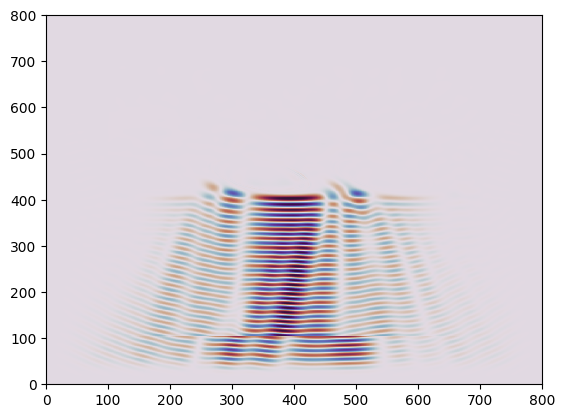

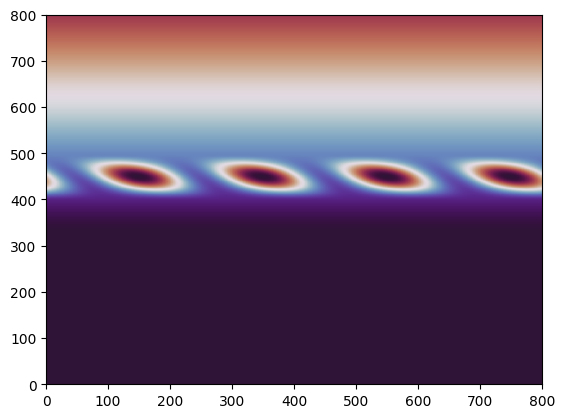

In [3]:
import sys
import numpy as np
from numba import jit #library for calculation in C
import math
import cmath
import os
import glob
import h5py as h5
import copy
import time
import random as rand
from scipy.interpolate import griddata
from scipy.signal import medfilt
from scipy.signal import savgol_filter
from scipy.signal import chirp, sweep_poly
import multiprocessing as mp
import matplotlib.pyplot as plt
import matplotlib.cm as cm

path_fluid='Turbulence_map.h5'
path_Working='' #path for the working directory
sys.path.append(path_Working)


###############################################################################
# PHYSICS CONSTANTS
###############################################################################
c = 3.E8
ep0 = 8.85418782E-12
mu0 = 1.25663706E-6
e = 1.602E-19
me = 9.109E-31 

###############################################################################
# SIMULATION INPUT
###############################################################################
T=0                      #time point if an hdf5 file used
ind_phi_stable=5000      #time when phase is stabilized
f0=80E9                  #probing frequency
n_max=6e19               #maximum density for a linear profile
mode_A=6e19 
NX=800                   #grid size
NY=800
Xpml = 100               #PML size, to be smaller than NX, NY
Ypml = 100
tmax = 5500              #time step to stop the wave propagation
tsweep=tmax #when a frequency sweep starts - put >tmax to ignore this function
df0=0.25E9
f_steps=1
comment='test_code'

w0 = 2*math.pi*f0
dt = 1/(40.*f0) # 
dx = 2*c*dt 
dy = 2*c*dt
B_ampl=2.5*1.65           #Magnetic field amplitude 2.5 T at axes 1.65 m
plasma_size_x=NX*dx 
""" in m, minimum 6 wave lengths -> appr. 120 points after PML layer with 0 density
to avoid parasitic reflections, 0.13 for previous simul. plus the size of actual plasma"""
plasma_size_y=NY*dy
x_start=2.12              #position of the plasma box left edge
sourcei = Xpml+5          #Antenna position right in front of PML 
sourcej = int(NY/2.)      #Antenna position by default at the center of the box
waist = int(0.025/dx)     #waist of the beam
sourcewidth=2*waist       #size of the antenna
# sweep rates for a sweep test 
v_f=25e15/1               #25e17/1 25GHz in 0.01us slow sweep v_f=25e15/1  0.4GHz 45000 tps
v_w=2*math.pi*v_f         #25GHz in 0.01us
dop =0.0                  #shift to launch wave with an agle
profile_type=1            #0 zero 1 linear 2 GYSELA 3 fluid turbulence



def init(t,p,sigma,ww,tstart):
    """" Defines the source of the reflectometer signal at the antenna's plane"""
    if t>tstart*dt:
        return math.exp(-p**2/sigma**2)*cmath.exp(1j*((w0+v_w*(t-dt*tstart))*t-dt*v_w*(t-dt)))*(math.tanh(t/dt/10. - 3) + 1)/2./math.sqrt(mu0/ep0)
    else:
       return math.exp(-p**2/sigma**2)*cmath.exp(1j*(ww*t-dop*p))*(math.tanh(t/dt/10. - 3) + 1)/2./math.sqrt(mu0/ep0)

class loadHDF5():
    """"Loads hdf5"""
    def __init__(self, filename):
        fh5       = h5.File(filename, 'r')
        var_in_h5 = list(fh5.keys())
        self.keys = var_in_h5

        for str_var in var_in_h5:
            str_var_new = str_var.replace('%','_')
            var_tmp     = fh5[str_var]
            self.__dict__[str_var_new] = var_tmp
        fh5.close()                

class grid:
    """"Grid of the simulation which includes fields, currents and plasma frequencies"""
    def __init__(self, length, width, xpml, ypml):
        
        self.length = length
        self.width = width
        self.xpml = xpml
        self.ypml = ypml
        
        self.Er = np.full((length, width+1), 0. + 0j)
        self.Ey = np.full((length+1, width), 0. + 0j)
        self.Jr = np.full((length, width+1), 0. + 0j)
        self.Jy = np.full((length+1, width), 0. + 0j)
        self.Hz = np.full((length, width), 0. + 0j)
        self.Hz_source = []
        self.res = []

        self.Hzx = np.full((length, width), 0. + 0j)
        self.Hzy = np.full((length, width), 0. + 0j)
        self.sxpml = np.full((length, width), 0.)
        self.ssxpml = np.full((length, width), 0.)
        self.sypml = np.full((length, width), 0.)
        self.ssypml = np.full((length, width), 0.)

        self.density = np.full((length, width), 0.)
        self.B0 = np.full((length, width), 0.)
        self.wc = np.array([[e*self.B0[j,i]/me for i in range(width)]for j in range(length)])
        self.wp = np.sqrt(self.density*e**2/(ep0*me))

    
    def clear(self):
        self.Er = np.full((self.length, self.width+1), 0. + 0j)
        self.Ey = np.full((self.length+1, self.width), 0. + 0j)
        self.Jr = np.full((self.length, self.width+1), 0. + 0j)
        self.Jy = np.full((self.length+1, self.width), 0. + 0j)
        self.Hz = np.full((self.length, self.width), 0. + 0j)
        self.Hzx = np.full((self.length, self.width), 0. + 0j)
        self.Hzy = np.full((self.length, self.width), 0. + 0j)
        self.res = []
        self.Hz_source = []
        
    def next_step(self, t, sourcei, sourcej, source_width,f):
        """"One step of the simulation redefinig the source and calculating all the fields"""
        w = 2*math.pi*f
        self.res.append(self.Ey[sourcei,sourcej])
        width = self.width
        length = self.length
        xpml = self.xpml
        ypml = self.ypml

        for j in range(sourcej - source_width-1, sourcej + source_width + 1):       
            self.Hz[sourcei, j] += init(t, j-sourcej,waist,w,tsweep)       
        self.Hz_source.append(self.Hz[sourcei, sourcej])
        self.Er,self.Ey,self.Hz,self.Hzx,self.Hzy,self.Jr,self.Jy=next_step_numba(width, length, xpml, ypml,dt, mu0,ep0,dx,dy,self.sxpml,self.ssxpml,self.sypml,self.ssypml,self.Er,self.Ey,self.Hz,self.Hzx,self.Hzy,self.Jr,self.Jy,self.wc,self.wp)      

@jit("Tuple((complex128[:,:],complex128[:,:],complex128[:,:],complex128[:,:],complex128[:,:],complex128[:,:],complex128[:,:]))(int64,int64,int64,int64,float64,float64,float64,float64,float64,float64[:,:],float64[:,:],float64[:,:],float64[:,:],complex128[:,:],complex128[:,:],complex128[:,:],complex128[:,:],complex128[:,:],complex128[:,:],complex128[:,:],float64[:,:],float64[:,:])",nopython=True,cache=True)
def next_step_numba(width, length, xpml, ypml,dt, mu0,ep0,dx,dy,sxpml,ssxpml,sypml,ssypml,Er,Ey,Hz,Hzx,Hzy,Jr,Jy,wc,wp):
    """"Fileds calculation accelerated with numba"""    
    Er_2=Er.copy()
    Ey_2=Ey.copy()
    Hz_2=Hz.copy()
    Hzx_2=Hzx.copy()
    Hzy_2=Hzy.copy()
    Jr_2=Jr.copy()
    Jy_2=Jy.copy()
    
    Er_2[:,0]=0
    Er_2[:,width]=0
    Ey_2[0,:]=0
    Ey_2[length,:]=0  

    for j in range(width):
        for i in range(length):

            if i <= xpml-1 or i >= length - xpml or j <= ypml-1 or j >= width - ypml : 
                Hzx_2[i,j] = math.exp(-ssxpml[i,j]*dt/mu0)*Hzx_2[i,j] - dt/(mu0*dx)*(Ey[i+1,j] - Ey[i,j])
                Hzy_2[i,j] = math.exp(-ssypml[i,j]*dt/mu0)*Hzy_2[i,j] + dt/(dy*mu0)*(Er[i,j+1] - Er[i,j])        
                   
            else :
                Jr_2[i,j] = (1-wc[i,j]**2*dt**2/4.)/(1 + wc[i,j]**2*dt**2/4.)*Jr[i,j] - wc[i,j]*dt/(1+wc[i,j]**2*dt**2/4.)*(Jy[i,j] + Jy[i,j-1] + Jy[i+1,j] + Jy[i+1, j-1])/4. + ep0*wp[i,j]**2*dt/(1+wc[i,j]**2*dt**2/4.)*(Er[i,j]-wc[i,j]*dt/2.*(Ey[i+1,j] + Ey[i,j]+ Ey[i, j-1] + Ey[i+1, j-1])/4.)
                Jy_2[i,j] = (1-wc[i,j]**2*dt**2/4.)/(1 + wc[i,j]**2*dt**2/4.)*Jy[i,j]+ wc[i,j]*dt/(1+wc[i,j]**2*dt**2/4.)*(Jr[i,j+1] + Jr[i-1,j+1]+ Jr[i, j] + Jr[i-1, j])/4. + ep0*wp[i,j]**2*dt/(1+wc[i,j]**2*dt**2/4.)*(Ey[i,j]+wc[i,j]*dt/2.*(Er[i,j+1] + Er[i-1,j+1]+ Er[i, j] + Er[i-1, j])/4.)
                Hz_2[i,j] = Hz_2[i,j] + dt/(mu0*dy)*(Er[i, j+1] - Er[i, j]) - dt/(mu0*dx)*(Ey[i+1,j] - Ey[i, j])


    for j in range(width+1):
        for i in range(length):
            if j != width:
                if (i<xpml or j <ypml or i > length - xpml-1 or j > width - ypml) :
                    Er_2[i,j] = math.exp(-sypml[i,j]*dt/ep0)*Er_2[i,j] + dt/(ep0*dy)*(Hzx_2[i,j] -Hzx_2[i,j-1] + Hzy_2[i,j] -Hzy_2[i,j-1])- dt/ep0*Jr_2[i,j]
                    
                elif j == ypml :
                    Er_2[i,j] = math.exp(-sypml[i,j]*dt/ep0)*Er_2[i,j] + dt/(ep0*dy)*(Hz_2[i,j]-Hzx_2[i,j-1] - Hzy_2[i,j-1] )- dt/ep0*Jr_2[i,j]
                    
                elif j == width - ypml:
                    Er_2[i,j] = math.exp(-sypml[i,j]*dt/ep0)*Er_2[i,j] + dt/(ep0*dy)*(Hzx_2[i,j] + Hzy_2[i,j] - Hz_2[i,j-1]) - dt/ep0*Jr_2[i,j]
                    
                else :
                    Er_2[i,j] = Er_2[i,j] + dt/(dy*ep0)*(Hz_2[i,j]- Hz_2[i,j-1]) - dt/ep0*Jr_2[i,j]
                
            else : 
                Er_2[i,j] = math.exp(-sypml[i,j-1]*dt/ep0)*Er_2[i,j] + dt/(ep0*dy)*(-Hzx_2[i,j-1] - Hzy_2[i,j-1])- dt/ep0*Jr_2[i,j]
        
    
        
    for j in range(width):
        for i in range(length+1): 
            if i != length :
                    
                if (i<xpml or j < ypml or i > length - xpml or j > width - ypml - 1) :
                    Ey_2[i,j] = math.exp(-sxpml[i,j]*dt/ep0)*Ey_2[i,j] - dt/(ep0*dx)*(Hzx_2[i,j] -Hzx_2[i-1,j] + Hzy_2[i,j] - Hzy_2[i-1,j])- dt/ep0*Jy_2[i,j]
                    
                elif i == xpml : 
                    Ey_2[i,j] = math.exp(-sxpml[i,j]*dt/ep0)*Ey_2[i,j] - dt/(ep0*dx)*(Hz_2[i,j]-Hzx_2[i-1,j] - Hzy_2[i-1,j]) - dt/ep0*Jy_2[i,j]
                    
                elif i == length - xpml :
                    Ey_2[i,j] = math.exp(-sxpml[i,j]*dt/ep0)*Ey_2[i,j] - dt/(ep0*dx)*(Hzx_2[i,j] + Hzy_2[i,j] - Hz_2[i-1,j]) - dt/ep0*Jy_2[i,j]
                    
                else : 
                    Ey_2[i,j] = Ey_2[i,j] - dt/(ep0*dx)*(Hz_2[i, j] -Hz_2[i-1,j]) - dt/ep0*Jy_2[i,j]
                        
            else : 
                Ey_2[i,j] = math.exp(-sxpml[i-1,j]*dt/ep0)*Ey_2[i,j] - dt/(ep0*dx)*(-Hzx_2[i-1,j] - Hzy_2[i-1,j]) - dt/ep0*Jy_2[i,j]
    
    return Er_2,Ey_2,Hz_2,Hzx_2,Hzy_2,Jr_2,Jy_2
           
def PML(simul, sigmam, n):
    for j in range(simul.width):
        for i in range(simul.xpml):
            simul.sxpml[i,j] = sigmam*((simul.xpml - i)/float(simul.xpml))**(n)
            simul.ssxpml[i,j] = (mu0/(ep0))*simul.sxpml[i,j]
            
    for j in range(simul.width):
        for i in range(simul.length - simul.xpml -1 , simul.length):
            simul.sxpml[i,j] =sigmam*((i - simul.length + simul.xpml + 1)/float(simul.xpml))**(n)
            simul.ssxpml[i,j] =(mu0/(ep0))*simul.sxpml[i,j]
            
    for i in range(simul.length):
        for j in range(simul.ypml):
            simul.sypml[i,j] = sigmam*((simul.ypml - j)/float(simul.ypml))**(n)
            simul.ssypml[i,j] =(mu0/(ep0))*simul.sypml[i,j]
            
    for i in range(simul.length):
        for j in range(simul.width - simul.ypml -1, simul.width):
            simul.sypml[i,j] = sigmam*((j - simul.width + simul.ypml +1)/float(simul.ypml))**(n)
            simul.ssypml[i,j] = (mu0/(ep0))*simul.sypml[i,j]
###############################################################################
# Useful routines
###############################################################################
def wp(density):
    """"Plasma frequency"""
    return np.array([[math.sqrt(max(0.00001, density[j,i]*e**2/(ep0*me))) for i in range(NY)]for j in range(NX)])

def N2(w, wc, wp): 
    """ Square refractive index"""
    return np.array([[(1 - (wp[i,j]/w)**2*((w**2 - wp[i,j]**2)/(w**2-wc[i,j]**2 - wp[i,j]**2))) for j in range(NY)] for i in range(NX)])

def Nx(w,wc,wp):
    """ Real refractive index """
    Nx = []
    N = N2(w,wc,wp)
    for i in range(NX):
        if N[i][50]>0:
            Nx.append(math.sqrt(N[i][50]))
        else :
            Nx.append(0)
    return Nx

def COL(w,wc,wp):
    """Returns the position of the cut-off layer"""
    
    cut=[0 for i in range(NY)]
    N = N2(w,wc,wp)
    for i in range(NY):
        for j in range(NX-1) :
            if N[j,i]*N[j+1,i]<0 :
                cut[i] = j- N[j,i]/(N[j+1,i] - N[j,i])
                break
    return cut
def plot_phi_w(f0,phi_0):
    """WKB phase calculation for f_steps of probing frequency"""
    ff=np.linspace(f0,f0+(f_steps-1)*df0,f_steps)
    w=np.array(2*math.pi*ff)
    ne_7=(density0)
    wp=(np.sqrt(np.abs(ne_7*e**2/(ep0*me))))
    r_t=[]
    for i in range(f_steps):
        r_t.append(COL(2*math.pi*ff[i],wc,wp))
    r_t=np.array(r_t)
    r_t=r_t[:,round(NY/2)]
    phi_w=[]
    for i in range(f_steps):
        phi_w.append(phi_WKB(r_t[i],w[i], wc, wp,dx))
    return 0

def phi_WKB(i,w,wc,wp, dx):
    """Returns the dephasing following WKB equations, for a cut-off layer at position i, and a space interval dx"""
    wkb = 0
    Nx0 = Nx(w,wc,wp)
    if i<NX-Xpml-1:
        for k in range(Xpml+1, int(i)+1):
            wkb += dx*Nx0[k]
        wkb = wkb*2*w/c - math.pi/2
        wkb += (i - int(i))*dx*Nx0[int(i)]*w/c
    return wkb

def correction(density, nec, ic, di):
    A0 = nec - ((density[int(ic)+1] - density[int(ic)])*(ic - int(ic)) + density[int(ic)])
    a0 = A0
    a2 = -2*A0/float(di)**2
    a4 = A0/float(di)**4
    for i in range(int(ic) - di, min(int(ic) + di+1, NX)):
        density[i] += a0 + a2*(i-ic)**2 + a4*(i-ic)**4

def interp(col,i0, width):
    x1 = i0-width
    x2 = i0 + width
    y1 = (col[int(x1)+1] - col[int(x1)])*(x1-int(x1)) + col[int(x1)]
    y2 = (col[int(x2)+1] - col[int(x2)])*(x2-int(x2)) + col[int(x2)]
    yy1 = col[int(x1)+1] - col[int(x1)]
    yy2 = col[int(x2)+1] - col[int(x2)]
    M = np.array([[1, x1, x1**2, x1**3], [1,x2,x2**2, x2**3], [0,1,2*x1,3*x1**2], [0,1,2*x2,3*x2**2]])
    B = np.array([[y1], [y2], [yy1], [yy2]])
    A = np.dot(np.linalg.inv(M),B)
    for i in range(int(x1),int(x2)+1):
        col[i] = A[0] + A[1]*(i) + A[2]*(i)**2 + A[3]*(i)**3


def sin_fluct(a,i,L,t,T):
    return a*math.sin(i*2*math.pi/float(L) - 2*math.pi/float(T)*t)

def nec0(dens, w):
    col = COL(w, wc, wp(dens))[100]
    nec = (dens[int(col)+1,100] - dens[int(col),100])*(col - int(col)) + dens[int(col),100]
    return nec

def trace_wx(density0, wc, NX):
    """Get the cutoff frequency for all radial positions"""
    ne_7=np.flipud(density0[:,0])
    wc_7=np.flipud(wc[:,0])
    wp_7=np.sqrt(np.abs(ne_7*e**2/(ep0*me)))
    wxx=[]
    for j in range(0,NX):
        wxx.append(0.5*(wc_7[j]+math.sqrt(wc_7[j]**2+4*wp_7[j]**2)))
    wxx=np.array(wxx)
    return wxx

###############################################################################
# Running the simulation
###############################################################################
    
B0 = np.array([[B_ampl/float(x_start+NX*dx-j*dx) for i in range(NY)] for j in range(NX)]) # Magnetic field defined as 1/R
wc = np.array([[e*B0[j,i]/me for i in range(NY)]for j in range(NX)])

t=T
density0=np.zeros((NX,NY))

if profile_type==1:
    pos_0=NX-Xpml-240 #6 wavelengths of 0 density
    for i in range(NY):
        density0[0:pos_0,i]=np.linspace(n_max,0,pos_0)
        for j in range(pos_0-10,pos_0+10):
            density0[j-1,i]=n_max*(j-pos_0-10)**2/(pos_0)/40
        for k in range(300,400):
            density0[k,i]+=mode_A*(np.sin(k*2*np.pi/200)*np.sin(i*2*np.pi/400))**2
   

    for j in range(300,400):
        density0[j,:]=np.roll(density0[j,:],(j-300))     
            
        #smooth density
    
    x_fac=np.linspace(0,NX-1,NX)
    y_fac=1+np.tanh((x_fac-10-Xpml)/(60)) #3 wavelengths of 0 smooth density -200, /60
    ne=np.flipud(density0)
    ne1=ne.T*y_fac
    density0=ne1.T
            
if profile_type==3: 
    ne_data = h5.File(path_fluid,'r')
    density0=np.flipud(n_max*ne_data["ne_map"][t,:,:])


phi_0=[]
results = []
Ey_ant=[]
S_ant=[]
simul0 = grid(NX,NY,Xpml,Ypml)
simul0.clear()
simul0.wc = wc
simul0.density = density0
simul0.wp = wp(simul0.density)
PML(simul0, 10. , 4.)
tt=0
for k in range(tmax):
    simul0.next_step(k*dt, sourcei, sourcej, sourcewidth,f0)
    tt=tt+1
    if tt==ind_phi_stable:
        Ey_ant.append(simul0.Ey[Xpml+5,:])
    if tt>ind_phi_stable:
        Ey_ant.append(simul0.Ey[Xpml+5,:])
if Ey_ant==[]: #in case of a simulation shorter than the time of phase stabilization
    Ey_ant.append(simul0.Ey[Xpml+5,:])
sourceEy=simul0.res
results.append(simul0.res)
Ey_ant=np.array(Ey_ant)
E_int=sum(abs(Ey_ant[0,:]))
Ey_end=np.array(simul0.Ey[sourcei,:])
for ll in range(NY):
    S_ant.append((Ey_end[ll]*cmath.exp(-1j*w0*tmax*dt)-Ey_ant[0,ll]*cmath.exp(-1j*w0*ind_phi_stable*dt))*abs(Ey_ant[0,ll]))
phi_0.append(cmath.phase(sum(S_ant)/E_int))
amp_0=abs(sum(S_ant)/E_int)
#plot simul0.Ey and density0 to check
np.save(path_Working+'sourceEy_' + str(round(f0/1e7)) +comment+'.npy', results[t])
np.save(path_Working+'Ey_ant_' + str(round(f0/1e7)) +comment+'.npy', Ey_ant)
np.save(path_Working+'Ey_final_' + str(round(f0/1e7)) +comment+'.npy', simul0.Ey)
np.save(path_Working+'amp_avg_' + str(round(f0/1e7))+comment+'.npy', amp_0)    
np.save(path_Working+'phi_avg_' + str(round(f0/1e7))+comment+'.npy', phi_0)

plt.figure(1)
plt.pcolor(np.real(simul0.Ey),cmap=cm.twilight_shifted)
plt.figure(2)
plt.pcolor(np.real(simul0.density),cmap=cm.twilight_shifted)

In [4]:
print(phi_0,amp_0)

[1.842747764954763] 0.0028980375737413543
